In [59]:
import streamlit as st
import pandas as pd


from mainnet_launch.constants import AutopoolConstants, CACHE_TIME, eth_client
from mainnet_launch.constants import BAL_ETH, AUTO_ETH, AUTO_LRT
from mainnet_launch.lens_contract import get_pools_and_destinations_call
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks
from mainnet_launch.destinations import DestinationDetails, get_destination_details
from mainnet_launch.data_fetching.get_state_by_block import build_blocks_to_use

def _fetch_destination_depeg_details(autopool: AutopoolConstants, blocks) -> pd.Series:
    """
    Returns a dataframe with one column `nav_per_share_if_no_discount` for each block in blocks.
    """
    details = [d for d in get_destination_details() if d.autopool == autopool]
    # autopoolNav in Idle df
    lp_token_addresss_to_name = {d.lpTokenAddress: d.vault_name for d in details if d.lpTokenAddress is not None}

    pool_and_destinations_df = get_raw_state_by_blocks([get_pools_and_destinations_call()], blocks)

    def _extract_totalEthValueHeldIfNoDiscount(row: dict):

        for a, destination_list in zip(row["autopools"], row["destinations"]):
            if a["poolAddress"].lower() == autopool.autopool_eth_addr.lower():
                # Something is wrong, not sure what yet
  

                totalEthValueHeldIfNoDiscount = {
                    autopool.name: a["totalIdle"] / 1e18
                }  # ETH in idle is not at any disocunt
                all_destinations = []
                for dest in destination_list:
                    if dest['lpTokenAddress'].lower() in lp_token_addresss_to_name:
                        vault_name = lp_token_addresss_to_name[dest['lpTokenAddress']]
                    if vault_name == 'ECLP-wstETH-wETH (balancer)':
                        all_destinations.append(dest)
                
                print(len(all_destinations))
                # discounts = [lst_stats["discount"] / 1e18 for lst_stats in dest["lstStatsData"]]
                # valueHeldInEth = [t["valueHeldInEth"] / 1e18 for t in dest["underlyingTokenValueHeld"]]
                # underlyingTokenSymbols = [t["symbol"] / 1e18 for t in dest["underlyingTokenSymbols"]]
                
                # return {'underlyingTokenSymbols': underlyingTokenSymbols}, 'valueHeldInEth':, valueHeldInEth, 'discounts':discounts}
                #     # a positive discount means we think the destination is trading at below its backing on the consensus layer
                #     # a negative disocunt means we think the destination is trading at more than the backing on the consensus layer
                #     # valueHeldInEth_removed_lst_discount = float(
                #     #     sum([value / (1 - discount) for discount, value, in zip(discounts, valueHeldInEth)])
                #     # )
                #     destination_name = lp_token_addresss_to_name[eth_client.toChecksumAddress(dest["lpTokenAddress"])]

                #     if destination_name not in totalEthValueHeldIfNoDiscount:
                #         totalEthValueHeldIfNoDiscount[destination_name] = valueHeldInEth_removed_lst_discount
                #     else:
                #         totalEthValueHeldIfNoDiscount[destination_name] += valueHeldInEth_removed_lst_discount

        return totalEthValueHeldIfNoDiscount

    def _extract_total_shares(row: dict):
        for a, _ in zip(row["autopools"], row["destinations"]):
            if a["poolAddress"].lower() == autopool.autopool_eth_addr.lower():
                return a["totalSupply"] / 1e18

    total_shares = pool_and_destinations_df["getPoolsAndDestinations"].apply(_extract_total_shares)

    eth_value_if_no_discount_df = pd.DataFrame.from_records(
        pool_and_destinations_df["getPoolsAndDestinations"].apply(_extract_totalEthValueHeldIfNoDiscount),
        index=pool_and_destinations_df.index,
    )

    eth_value_if_no_discount_df["nav_if_all_lp_tokens_return_to_peg"] = eth_value_if_no_discount_df.sum(axis=1)
    eth_value_if_no_discount_df["total_shares"] = total_shares
    eth_value_if_no_discount_df["nav_per_share_if_no_discount"] = (
        eth_value_if_no_discount_df["nav_if_all_lp_tokens_return_to_peg"] / eth_value_if_no_discount_df["total_shares"]
    )

    return eth_value_if_no_discount_df
blocks = build_blocks_to_use()
eth_value_if_no_discount_df = _fetch_destination_depeg_details(BAL_ETH, blocks)

2024-11-06 14:54:50.345 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:54:50.347 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:54:50.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:54:50.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:54:50.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:54:50.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:54:50.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:54:50.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

KeyError: 'vaultName'

In [ ]:


from mainnet_launch.constants import BAL_ETH, AUTO_ETH, AUTO_LRT
from mainnet_launch.data_fetching.get_state_by_block import build_blocks_to_use
from mainnet_launch.autopool_diagnostics.nav_if_no_discount import fetch_destination_totalEthValueHeldIfNoDiscount
from mainnet_launch.autopool_diagnostics.fetch_nav_per_share import _fetch_all_all_pool_nav_per_share

discount_allocation_df = fetch_destination_totalEthValueHeldIfNoDiscount(BAL_ETH, blocks)
nav_per_share_df = _fetch_all_all_pool_nav_per_share(blocks)

from mainnet_launch.destination_diagnostics.fetch_destination_summary_stats import fetch_destination_summary_stats

uwcr_df, allocation_df, compositeReturn_out_df, total_nav_series, summary_stats_df, priceReturn_df = (
    fetch_destination_summary_stats(blocks, BAL_ETH)
)
nav_per_share_df

2024-11-06 14:00:48.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.026 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

,autoETH,balETH,autoLRT
timestamp,,,
2024-09-15 02:04:47+00:00,1.000000,1.000000,1.000000
2024-09-15 05:44:35+00:00,1.000000,1.000000,1.000000
2024-09-15 09:24:47+00:00,1.000000,1.000000,1.000000
2024-09-15 13:04:11+00:00,1.000000,1.000000,1.000000
2024-09-15 16:44:23+00:00,1.000000,1.000000,1.000000
...,...,...,...
2024-11-06 01:04:59+00:00,1.002795,1.003415,1.002245
2024-11-06 04:44:23+00:00,1.002816,1.003457,1.002283
2024-11-06 08:24:23+00:00,1.002829,1.003497,1.002318


In [31]:
nav_df = discount_allocation_df[['nav_per_share_if_no_discount']].copy()
nav_df['nav_per_share'] = nav_per_share_df['balETH']
px.line(nav_df)

this makes me think it is an error, or we held mostly somethin gtrading at a preimum on the 17th

In [32]:
early_discount_df = discount_allocation_df[(discount_allocation_df.index > '9-16-2024') & (discount_allocation_df.index < '9-20-2024')].round(2)
early_allocation_df = allocation_df[(allocation_df.index > '9-16-2024') & (allocation_df.index < '9-20-2024')].round(2)

for col in early_allocation_df.columns:
    if col in early_discount_df.columns:
        df = pd.concat([early_discount_df[col], early_allocation_df[col]], axis=1)
        df.columns = ['less discount', 'with_discount']
        
        if early_discount_df[col].sum() > 0:
            px.line(df, title=col).show()
    else:
        print(col)

balETH (tokemak)


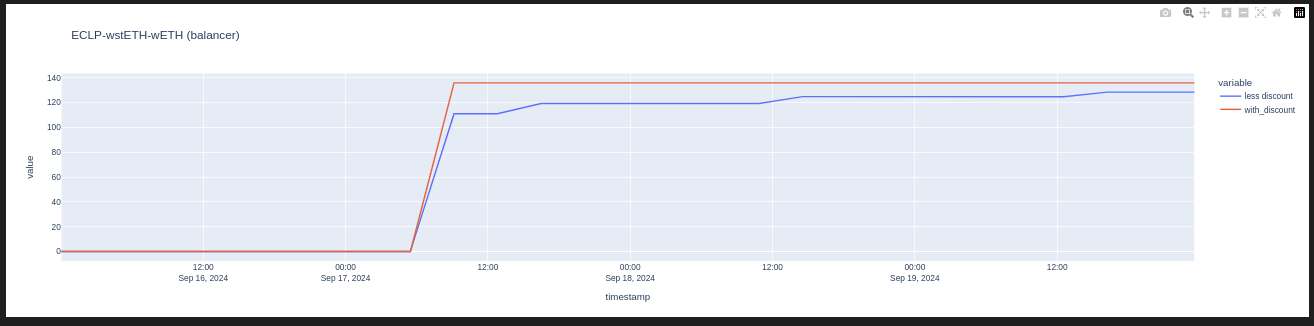

did one of these trade at a premium here?

In [33]:
from mainnet_launch.constants import AutopoolConstants, CACHE_TIME, eth_client
from mainnet_launch.lens_contract import get_pools_and_destinations_call
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks
from mainnet_launch.destinations import DestinationDetails, get_destination_details

details = [d for d in get_destination_details() if d.autopool == BAL_ETH]
# autopoolNav in Idle df
lp_token_addresss_to_name = {d.lpTokenAddress: d.vault_name for d in details if d.lpTokenAddress is not None}

pool_and_destinations_df = get_raw_state_by_blocks([get_pools_and_destinations_call()], blocks)
pool_and_destinations_df

2024-11-06 14:00:48.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.438 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.439 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.440 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:00:48.440 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


,getPoolsAndDestinations
timestamp,
2024-09-15 02:04:47+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 05:44:35+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 09:24:47+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 13:04:11+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 16:44:23+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
...,...
2024-11-06 01:04:59+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-11-06 04:44:23+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-11-06 08:24:23+00:00,{'autopools': [{'poolAddress': '0x0a2b94f6871c...


In [35]:
def _extract_asset_discounts(row):
    symbol_to_discount = {}

    for destinations in row['destinations']:
        for dest in destinations:
            symbols = [d['symbol'] for d in dest['underlyingTokenSymbols']]
            discounts = [round(100 * d['discount'] /1e18 , 4)for d in dest['lstStatsData']]
            for s, d in zip(symbols, discounts):
                if s in symbol_to_discount:
                    if symbol_to_discount[s] != d:
                        raise ValueError('discount and symbol different')
                else:
                    symbol_to_discount[s] = d
    return symbol_to_discount

lst_discounts = pd.DataFrame.from_records(
    pool_and_destinations_df["getPoolsAndDestinations"].apply(_extract_asset_discounts),
    index=pool_and_destinations_df.index,
)
px.line(lst_discounts)

/tmp/ipykernel_113692/3563144403.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [46]:
early_discount_df = discount_allocation_df[(discount_allocation_df.index > '9-16-2024') & (discount_allocation_df.index < '9-20-2024')].round(2)
early_allocation_df = allocation_df[(allocation_df.index > '9-16-2024') & (allocation_df.index < '9-20-2024')].round(2)


balancer_our_allocation_with_and_without_lst_discounts = pd.concat([early_discount_df['ECLP-wstETH-wETH (balancer)'], early_allocation_df['ECLP-wstETH-wETH (balancer)']], axis=1)
balancer_our_allocation_with_and_without_lst_discounts.columns = ['remove_discount', 'actual_value']

px.line(balancer_our_allocation_with_and_without_lst_discounts)

In [ ]:
recent_weETH_discounts = lst_discounts[(lst_discounts.index > '9-16-2024') & (lst_discounts.index < '9-20-2024')].round(2)
# I feel like something is wrong here, why is the actual value less then the value reduced the disoucnt
px.line(recent_weETH_discounts[['weETH', 'wstETH']])

In [ ]:
def fetch_destination_eth_value_held_in_each_token(autopool: AutopoolConstants, blocks) -> pd.Series:
    details = [d for d in get_destination_details() if d.autopool == autopool]
    # autopoolNav in Idle df
    lp_token_addresss_to_name = {d.lpTokenAddress: d.vault_name for d in details if d.lpTokenAddress is not None}

    pool_and_destinations_df = get_raw_state_by_blocks([get_pools_and_destinations_call()], blocks)

    def _extract_eth_value_of_underlying_assets_held(row: dict):
        eth_value_of_assets_held = {}

        for a, destination_list in zip(row["autopools"], row["destinations"]):
            if a["poolAddress"].lower() == autopool.autopool_eth_addr.lower():
                # overestimate because we hold more of the discounted asset than if the price was at peg
                # The invarients have the LP always holding more of the less valueable asset
                
                eth_value_of_assets_held['WETH'] =  a["totalIdle"] / 1e18
                
                for dest in destination_list:
                    symbols = [d['symbol'] for d in dest['underlyingTokenSymbols']]
                    valueHeldInEth = [t["valueHeldInEth"] / 1e18 for t in dest["underlyingTokenValueHeld"]]
                    
                    for s, v in zip(symbols, valueHeldInEth):
                        if s in eth_value_of_assets_held:
                            eth_value_of_assets_held[s] += v
 
                        else:
                            eth_value_of_assets_held[s] = v
        return eth_value_of_assets_held

    eth_value_per_asset_df = pd.DataFrame.from_records(
        pool_and_destinations_df["getPoolsAndDestinations"].apply(_extract_eth_value_of_underlying_assets_held),
        index=pool_and_destinations_df.index,
    )

    return eth_value_per_asset_df

eth_value_per_asset_df = fetch_destination_eth_value_held_in_each_token(BAL_ETH, blocks)
eth_value_per_asset_df

2024-11-06 14:13:09.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:13:09.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:13:09.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:13:09.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 14:13:09.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/tmp/ipykernel_113692/115289135.py:41: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,WETH,rETH,osETH,wstETH,cbETH,ETHx,ezETH,weETH,rswETH,rsETH,pxETH
timestamp,,,,,,,,,,,
2024-09-15 02:04:47+00:00,1.000000e-13,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2024-09-15 05:44:35+00:00,1.000000e-13,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2024-09-15 09:24:47+00:00,1.000000e-13,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2024-09-15 13:04:11+00:00,1.000000e-13,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2024-09-15 16:44:23+00:00,1.000000e-13,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-06 01:04:59+00:00,1.242458e+03,0.0,NaN,79.545359,NaN,155.285810,0.0,0.0,0.0,565.285327,2486.203596
2024-11-06 04:44:23+00:00,1.242010e+03,0.0,NaN,79.545359,NaN,155.285810,0.0,0.0,0.0,565.733220,2486.135437
2024-11-06 08:24:23+00:00,1.251673e+03,0.0,NaN,79.545359,NaN,155.285810,0.0,0.0,0.0,556.402921,2486.067073


In [51]:
early_eth_value_per_asset_df =  eth_value_per_asset_df[(eth_value_per_asset_df.index > '9-16-2024') & (eth_value_per_asset_df.index < '9-20-2024')].round(2)
px.line(early_eth_value_per_asset_df[['weETH']])

In [ ]:
# somethign is wrong